# Data processing tools for MATE Floats! lesson

Created by Ethan Campbell for NCAT/MATE/GO-BGC Marine Technology Summer Program

Tuesday, August 22, 2023

In [ ]:
import numpy as np                         # NumPy is an array and math library
import matplotlib.pyplot as plt            # Matplotlib is a visualization (plotting) library
import pandas as pd                        # Pandas lets us work with spreadsheet (.csv) data
import xarray as xr
from datetime import datetime, timedelta   # Datetime helps us work with dates and times

## Routine to process R/V Carson Carkeek `.cnv` cast files

In [ ]:
# May 2023 R/V Carson cruise data
# filepaths = ['/content/2023051001001_Carkeek.cnv','/content/2023051101001_Carkeek.cnv']
# export_filepaths = ['/content/2023051001001_Carkeek.csv','/content/2023051101001_Carkeek.csv']

# August 2023 R/V Carson MATE cruise data
filepaths = ['/content/20230825ctd01_Carkeek.cnv','/content/20230825ctd02_Carkeek.cnv']
export_filepaths = ['/content/20230825ctd01_Carkeek.csv','/content/20230825ctd02_Carkeek.csv']

casts = []
for idx, filepath in enumerate(filepaths):
  # Identify header line number (= line_idx - 1) and extract column names
  file_object = open(filepath,'r')
  all_lines = file_object.readlines()
  file_object.close()
  header_names = []
  preamble_to_save = []
  for line_idx, line in enumerate(all_lines):
    if line[0] == '*':
      preamble_to_save.append('# ' + line)
    if line[0] == '#':
      preamble_to_save.append(line)
    if '*END*' in line:
      break
    elif ' name' in line:
      header_names.append(line.split('= ')[1].split(':')[0])
  print('First line of data after header:',line_idx, line)
  print('Header column names:',header_names,'\n')

  # Load data
  cnv_data = pd.read_csv(filepath,header=None,names=header_names,
                        skiprows=line_idx+1,delim_whitespace=True)
  # data = pd.read_csv(filepath,comment='$',delim_whitespace=True,na_values='*',
  #                    header=None,names=col_names[2:])

  # Extract approximate cast (note: this only works for a CNV file with a single cast)
  first_sample_idx = np.argmax(np.diff(cnv_data['depSM'].rolling(window=17,center=True).mean()) > 0.03)
  last_sample_idx = np.where(np.diff(cnv_data['depSM'].rolling(window=17,center=True).mean()) > 0.03)[0][-1]
  cast = cnv_data.loc[first_sample_idx:last_sample_idx]
  cast.reset_index(inplace=True,drop=True)

  # De-spike cast data
  neg_spike_idx = cast['depSM'].index[cast['depSM'].diff() < -10].values
  pos_spike_idx = cast['depSM'].index[cast['depSM'].diff() > 10].values
  oxy_spike_idx = cast['sbeox0ML/L'].index[cast['sbeox0ML/L'] < 0.0].values
  all_spike_idx = np.sort(np.concatenate((neg_spike_idx,pos_spike_idx,oxy_spike_idx)))
  if len(all_spike_idx) > 0:
    cast = cast.drop(index=all_spike_idx)

  # Display and save cast data
  display(cast)
  casts.append(cast)

  # Export data and pre-pend with original header preamble
  cast.to_csv(export_filepaths[idx])
  with open(export_filepaths[idx], 'r+') as f:
    content = f.read()
    f.seek(0,0)
    f.write("".join(preamble_to_save) + content)

First line of data after header: 250 *END*

Header column names: ['altM', 'CStarTr0', 'c0mS/cm', 'density00', 'depSM', 'latitude', 'longitude', 'flECO-AFL', 'modError', 'sbeox0Mg/L', 'sbeox0ML/L', 'ph', 'potemp090C', 'prDM', 'sal00', 't090C', 'scan', 'flag'] 



,altM,CStarTr0,c0mS/cm,density00,depSM,latitude,longitude,flECO-AFL,modError,sbeox0Mg/L,sbeox0ML/L,ph,potemp090C,prDM,sal00,t090C,scan,flag
0,98.51,85.0319,36.454765,1022.5799,3.094,47.69744,-122.45666,1.6112,0,8.0144,5.6080,9.035,13.6443,3.121,30.2181,13.6447,5364,0.0
1,98.53,85.0319,36.454386,1022.5800,3.110,47.69744,-122.45666,1.6112,0,8.0145,5.6081,9.035,13.6439,3.137,30.2180,13.6443,5365,0.0
2,98.53,85.0575,36.450979,1022.5803,3.151,47.69744,-122.45666,1.6112,0,8.0096,5.6046,9.030,13.6407,3.177,30.2174,13.6411,5366,0.0
3,98.53,85.0319,36.447381,1022.5802,3.094,47.69744,-122.45666,1.6112,0,8.0143,5.6080,9.035,13.6374,3.121,30.2167,13.6378,5367,0.0
4,98.53,85.0319,36.447445,1022.5819,3.231,47.69744,-122.45666,1.6112,0,8.0139,5.6077,9.035,13.6360,3.258,30.2178,13.6364,5368,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9006,13.60,76.3392,36.207341,1024.1586,188.034,47.69732,-122.45778,0.2925,2,5.9266,4.1471,8.865,12.4265,189.707,30.8767,12.4508,14370,0.0
9007,13.55,76.3392,36.207467,1024.1587,188.034,47.69732,-122.45778,0.3218,2,5.9256,4.1464,8.865,12.4266,189.707,30.8768,12.4508,14371,0.0
9008,13.53,76.3392,36.207656,1024.1593,188.114,47.69732,-122.45778,0.3218,2,5.9247,4.1458,8.865,12.4263,189.788,30.8771,12.4506,14372,0.0
9009,13.53,76.3392,36.207278,1024.1589,188.098,47.69732,-122.45778,0.2925,2,5.9237,4.1451,8.865,12.4264,189.772,30.8767,12.4507,14373,0.0


First line of data after header: 250 *END*

Header column names: ['altM', 'CStarTr0', 'c0mS/cm', 'density00', 'depSM', 'latitude', 'longitude', 'flECO-AFL', 'modError', 'sbeox0Mg/L', 'sbeox0ML/L', 'ph', 'potemp090C', 'prDM', 'sal00', 't090C', 'scan', 'flag'] 



,altM,CStarTr0,c0mS/cm,density00,depSM,latitude,longitude,flECO-AFL,modError,sbeox0Mg/L,sbeox0ML/L,ph,potemp090C,prDM,sal00,t090C,scan,flag
0,98.53,84.5703,37.265011,1022.3681,2.294,47.69982,-122.45644,0.3511,0,8.1838,5.7265,9.033,14.6083,2.313,30.2016,14.6087,3917,0.0
1,98.51,84.5703,37.262911,1022.3688,2.438,47.69982,-122.45644,0.3804,0,8.1890,5.7302,9.038,14.6065,2.459,30.2011,14.6068,3918,0.0
2,98.53,84.5703,37.263164,1022.3679,2.118,47.69982,-122.45644,0.3804,0,8.1888,5.7300,9.038,14.6062,2.136,30.2017,14.6065,3919,0.0
3,98.51,84.5703,37.263674,1022.3684,2.254,47.69982,-122.45644,0.3511,0,8.1893,5.7304,9.033,14.6067,2.273,30.2017,14.6070,3920,0.0
4,98.53,84.5703,37.263546,1022.3673,2.062,47.69982,-122.45644,0.3804,0,8.1947,5.7341,9.033,14.6069,2.079,30.2015,14.6072,3921,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9253,13.33,69.1337,36.215576,1024.1453,184.981,47.69966,-122.45648,0.3511,0,5.9840,4.1872,8.846,12.4347,186.626,30.8793,12.4586,13170,0.0
9254,13.31,69.1337,36.215449,1024.1448,184.941,47.69966,-122.45648,0.3804,0,5.9894,4.1910,8.846,12.4350,186.585,30.8790,12.4589,13171,0.0
9255,13.31,69.1337,36.215513,1024.1451,184.981,47.69966,-122.45648,0.3804,0,5.9844,4.1875,8.846,12.4349,186.626,30.8791,12.4588,13172,0.0
9256,13.31,69.1337,36.215261,1024.1448,185.038,47.69966,-122.45648,0.3511,0,5.9842,4.1874,8.846,12.4353,186.683,30.8785,12.4592,13173,0.0


## Diagnostic plots for R/V Carson casts

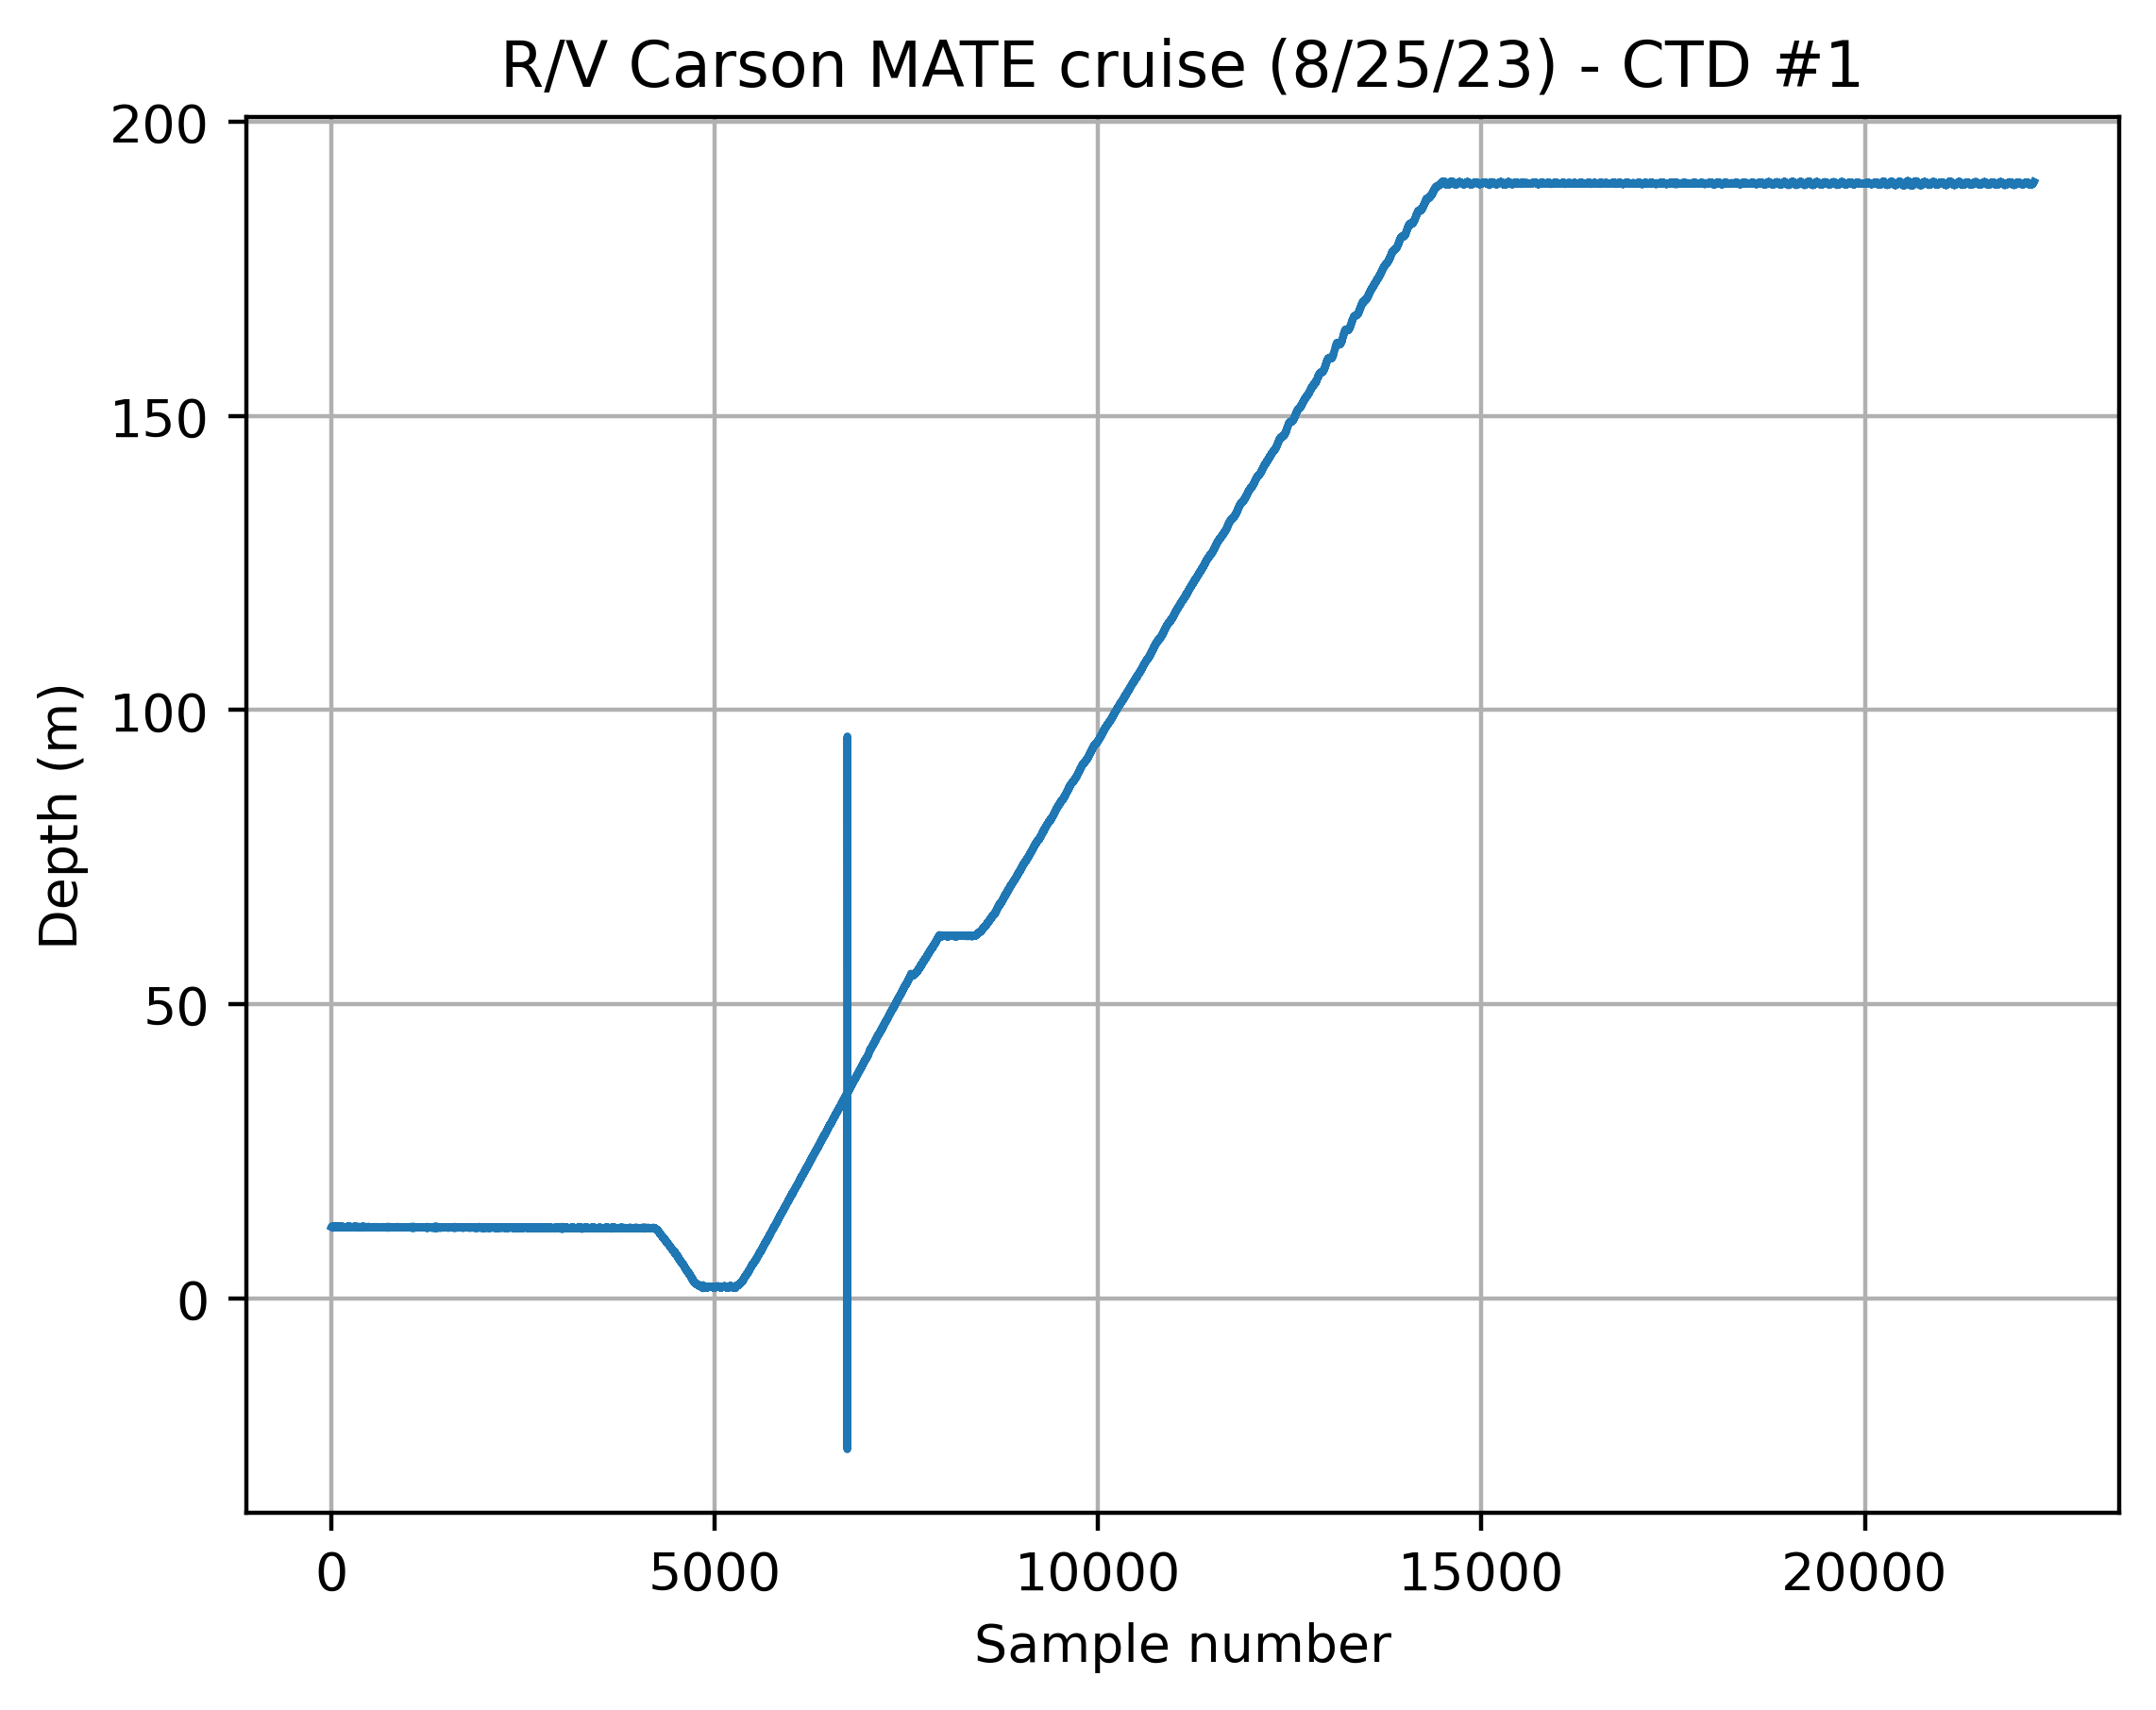

In [ ]:
plt.figure(dpi=400)
plt.plot(cnv_data['depSM'])
plt.xlabel('Sample number')
plt.ylabel('Depth (m)')
plt.title('R/V Carson MATE cruise (8/25/23) - CTD #1')
plt.grid();

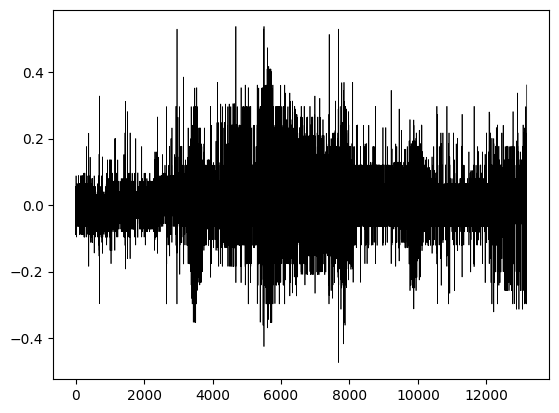

In [ ]:
plt.plot(np.diff(cnv_data['depSM']),lw=0.5,c='k')

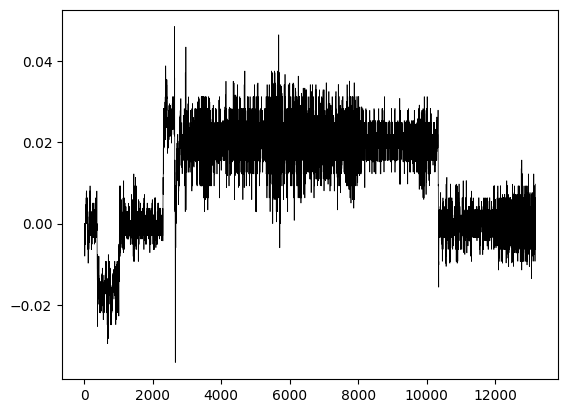

In [ ]:
plt.plot(np.diff(cnv_data['depSM'].rolling(window=19,center=True).mean()),lw=0.5,c='k')

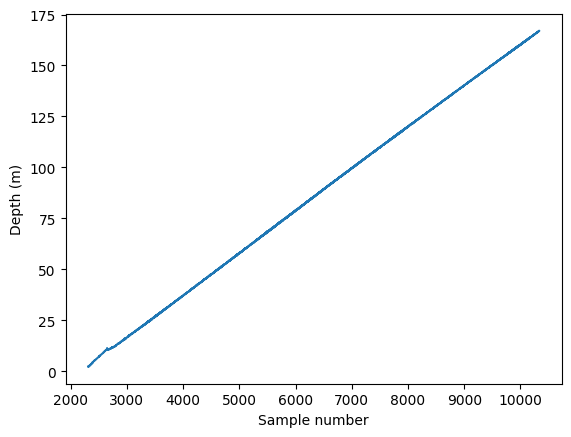

In [ ]:
plt.plot(casts[1]['depSM'])
plt.xlabel('Sample number')
plt.ylabel('Depth (m)');

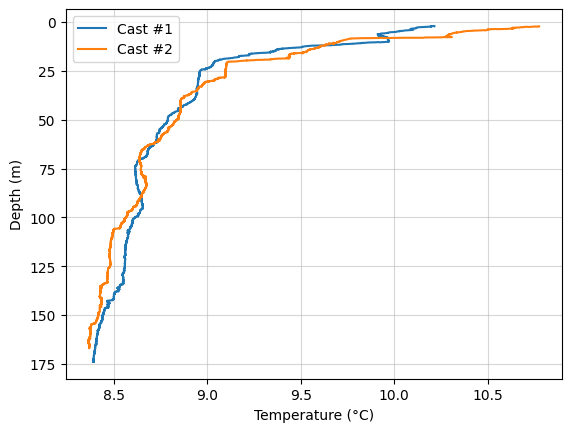

In [ ]:
plt.plot(casts[0]['t090C'],casts[0]['depSM'],label='Cast #1')
plt.plot(casts[1]['t090C'],casts[1]['depSM'],label='Cast #2')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)');

In [ ]:
casts[1]['t090C'].mean()

8.751454190571213

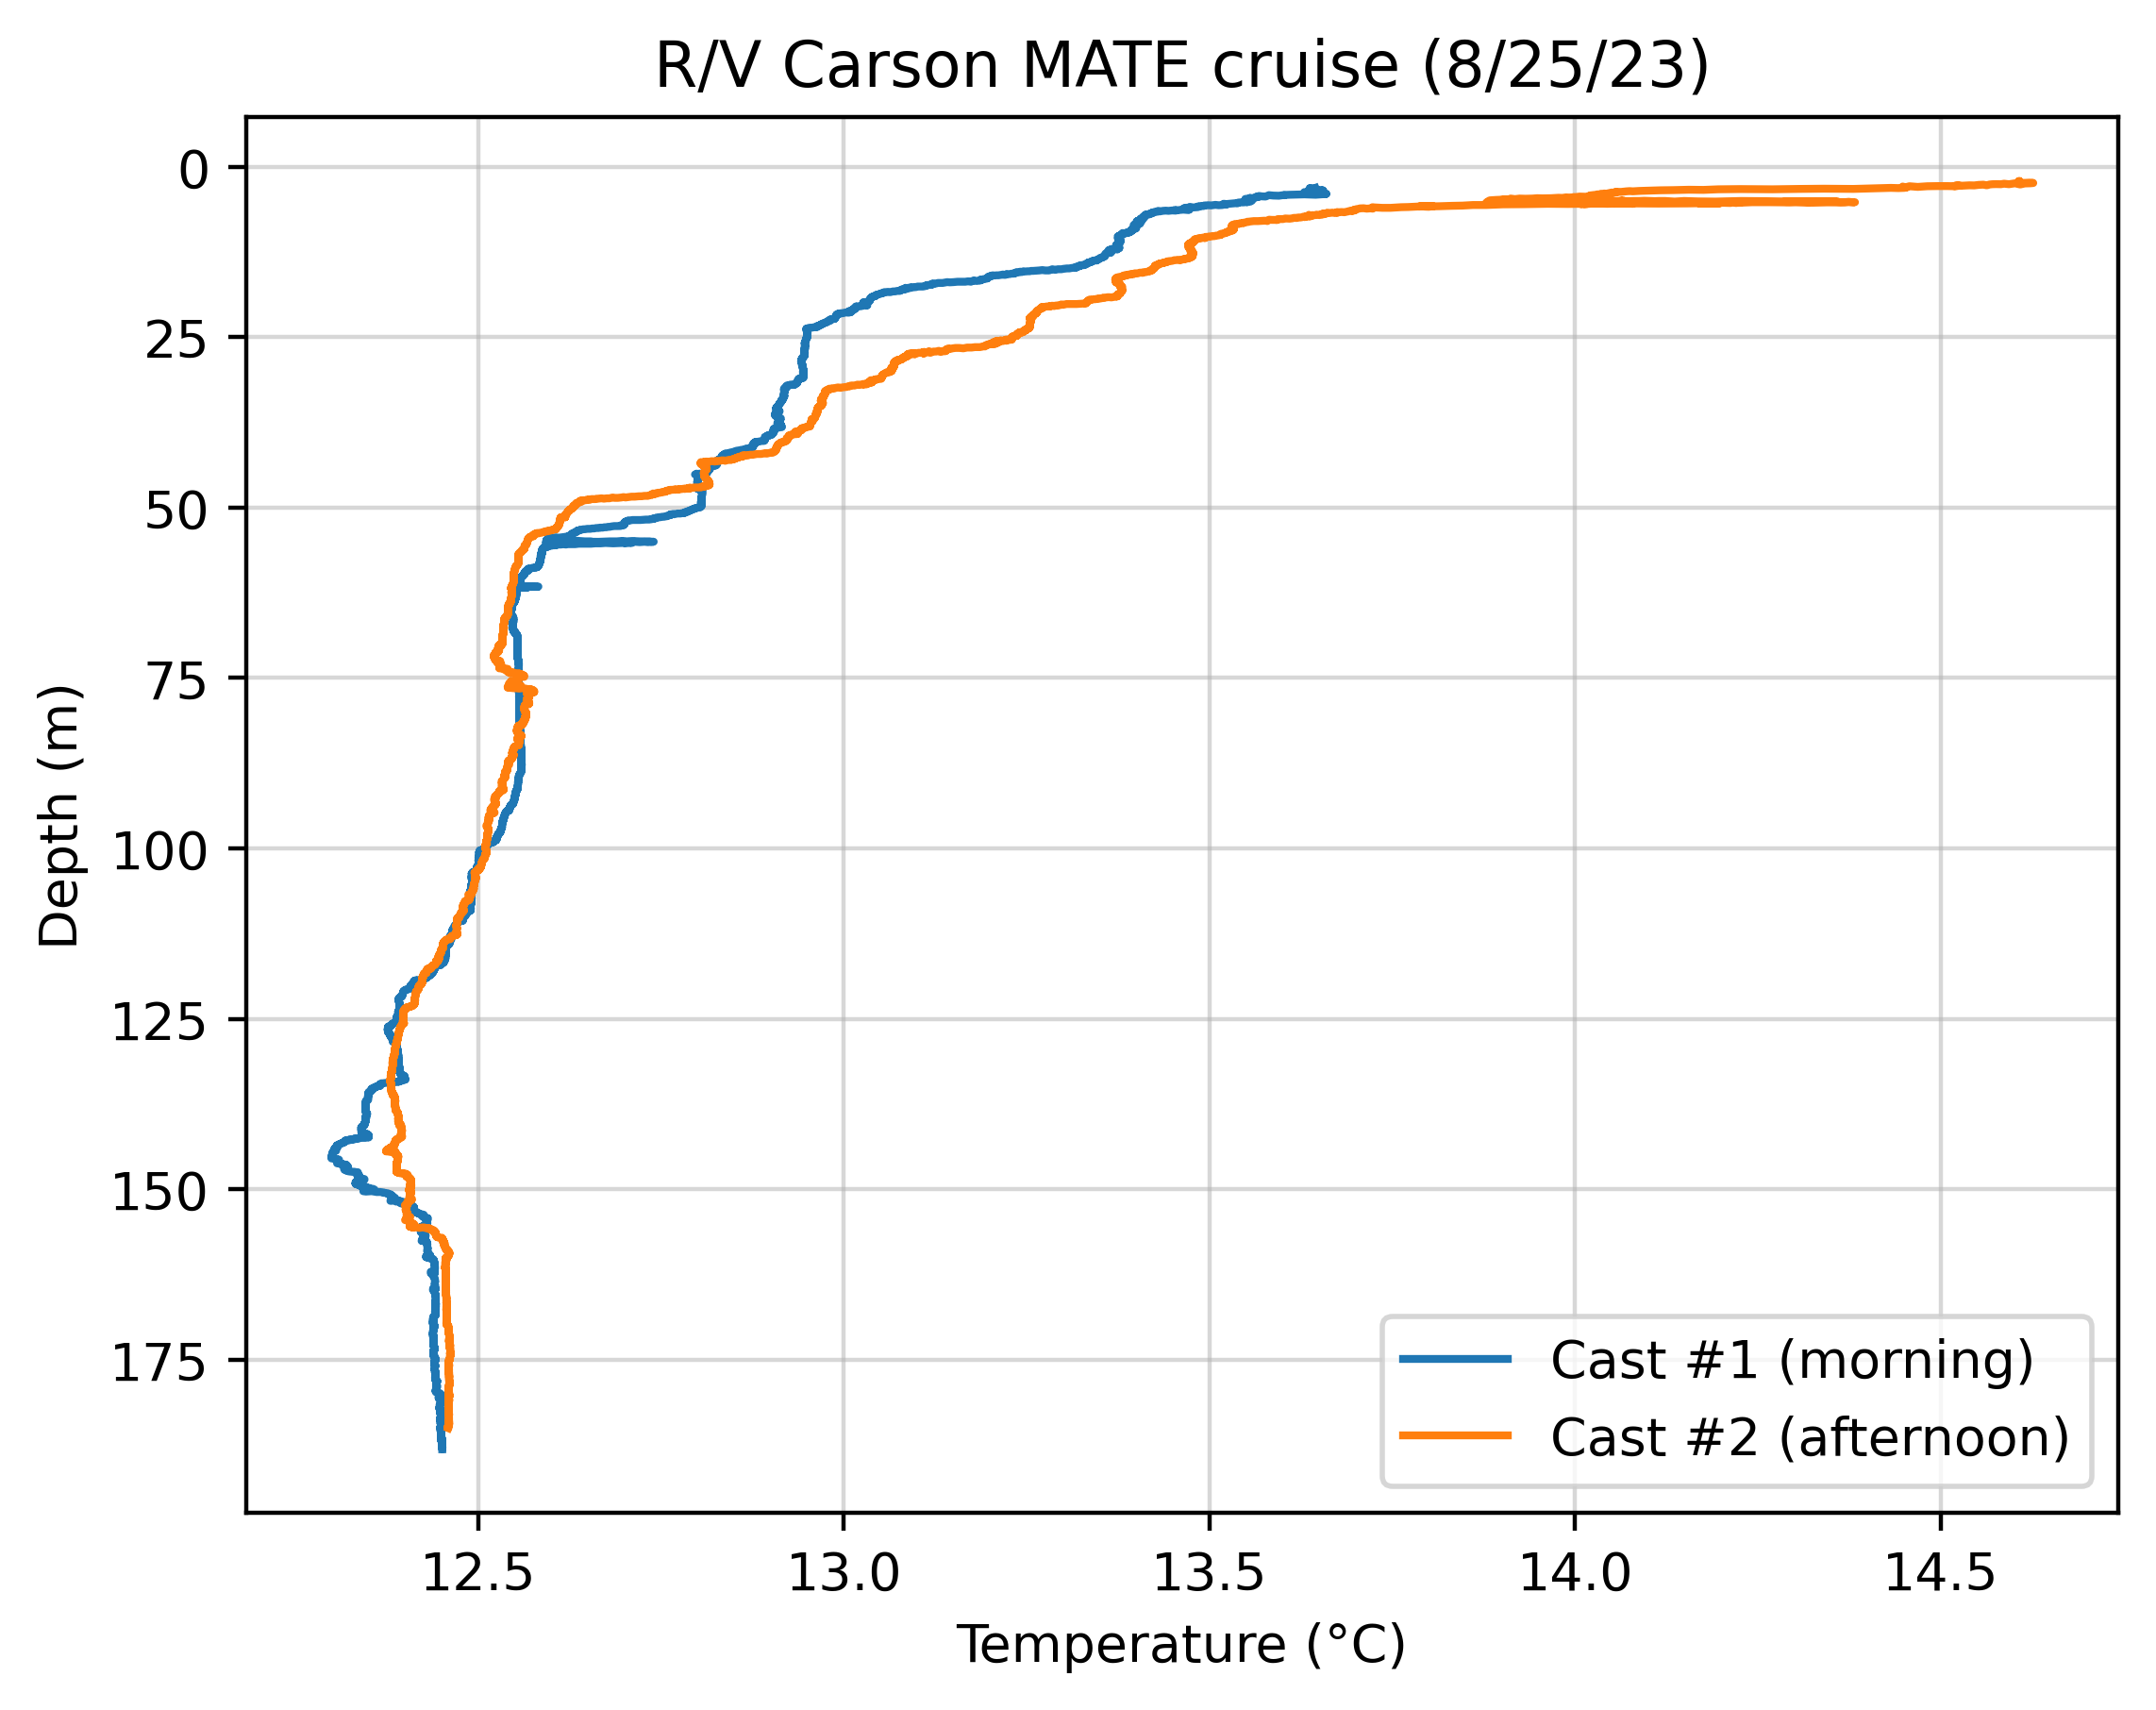

In [ ]:
plt.figure(dpi=400)
plt.plot(casts[0]['t090C'],casts[0]['depSM'],label='Cast #1 (morning)')
plt.plot(casts[1]['t090C'],casts[1]['depSM'],label='Cast #2 (afternoon)')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)')
plt.title('R/V Carson MATE cruise (8/25/23)');

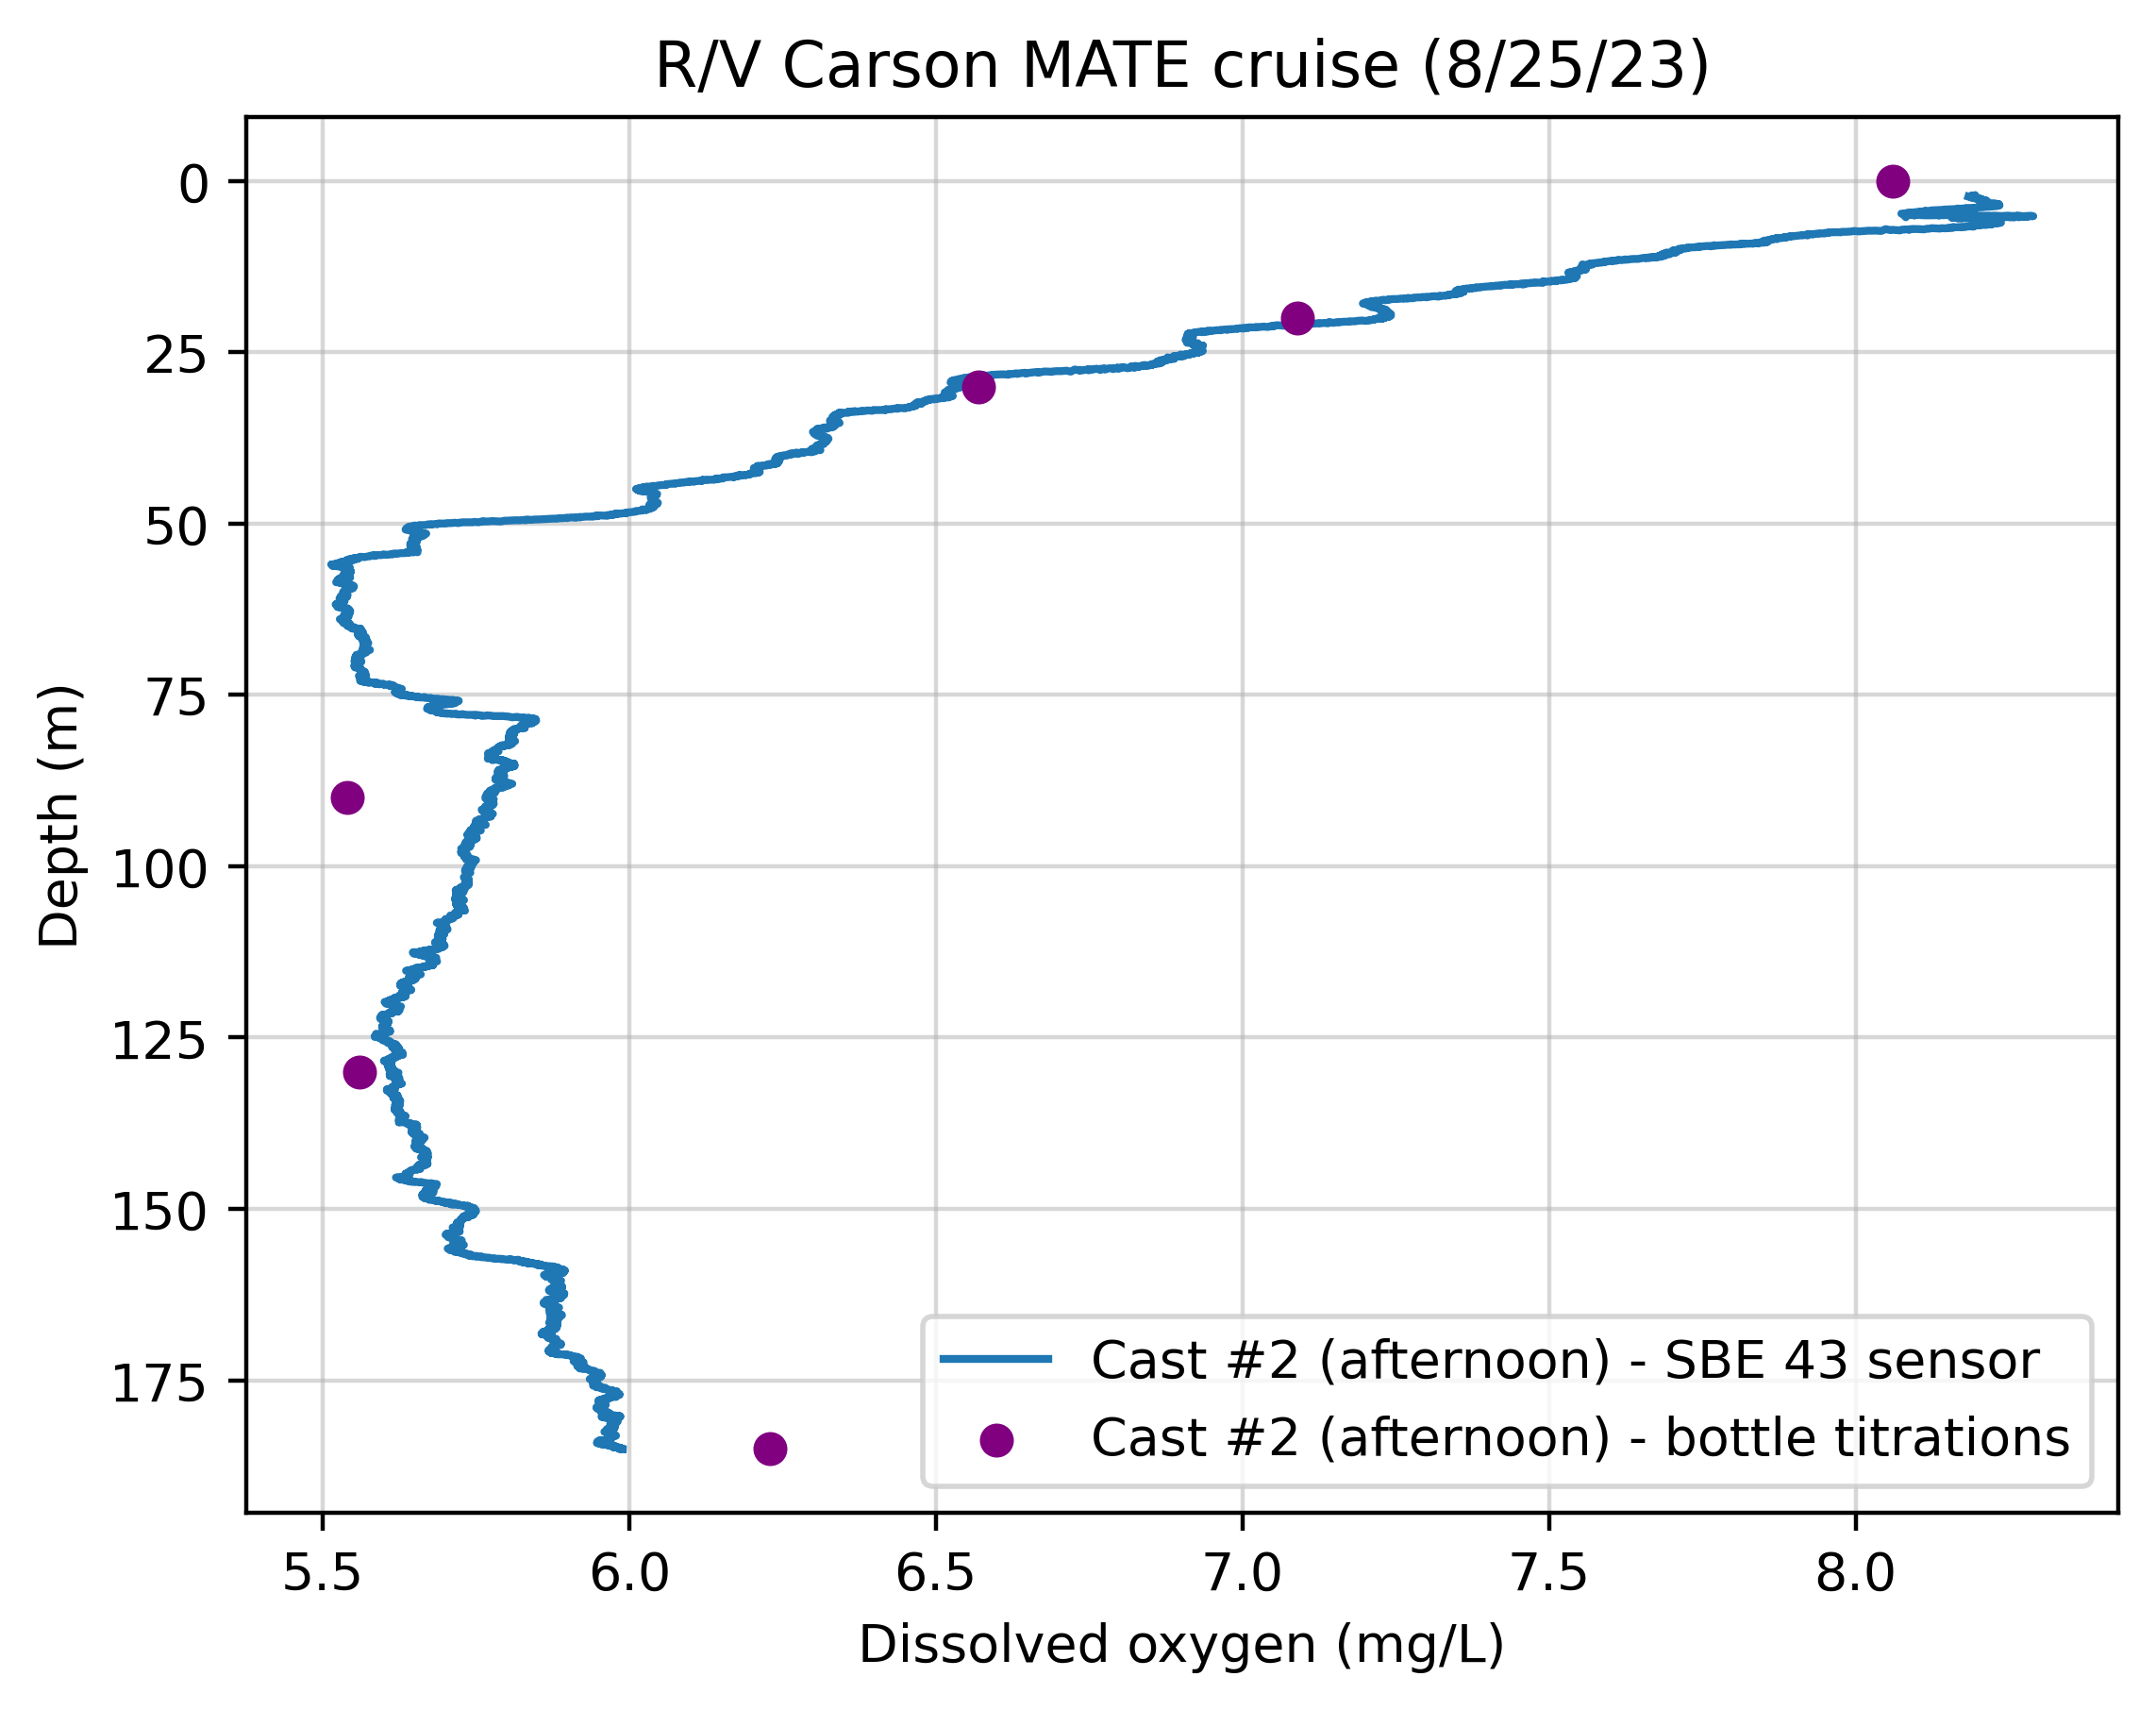

In [ ]:
oxy_bot_dep = [185,130,90,30,20,0]
oxy_bot_val = [6.23,5.56,5.54,6.57,7.09,8.06]

plt.figure(dpi=400)
plt.plot(casts[1]['sbeox0Mg/L'],casts[1]['depSM'],label='Cast #2 (afternoon) - SBE 43 sensor')
plt.scatter(oxy_bot_val,oxy_bot_dep,c='purple',s=30,zorder=2,label='Cast #2 (afternoon) - bottle titrations')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Dissolved oxygen (mg/L)')
plt.ylabel('Depth (m)')
plt.title('R/V Carson MATE cruise (8/25/23)');

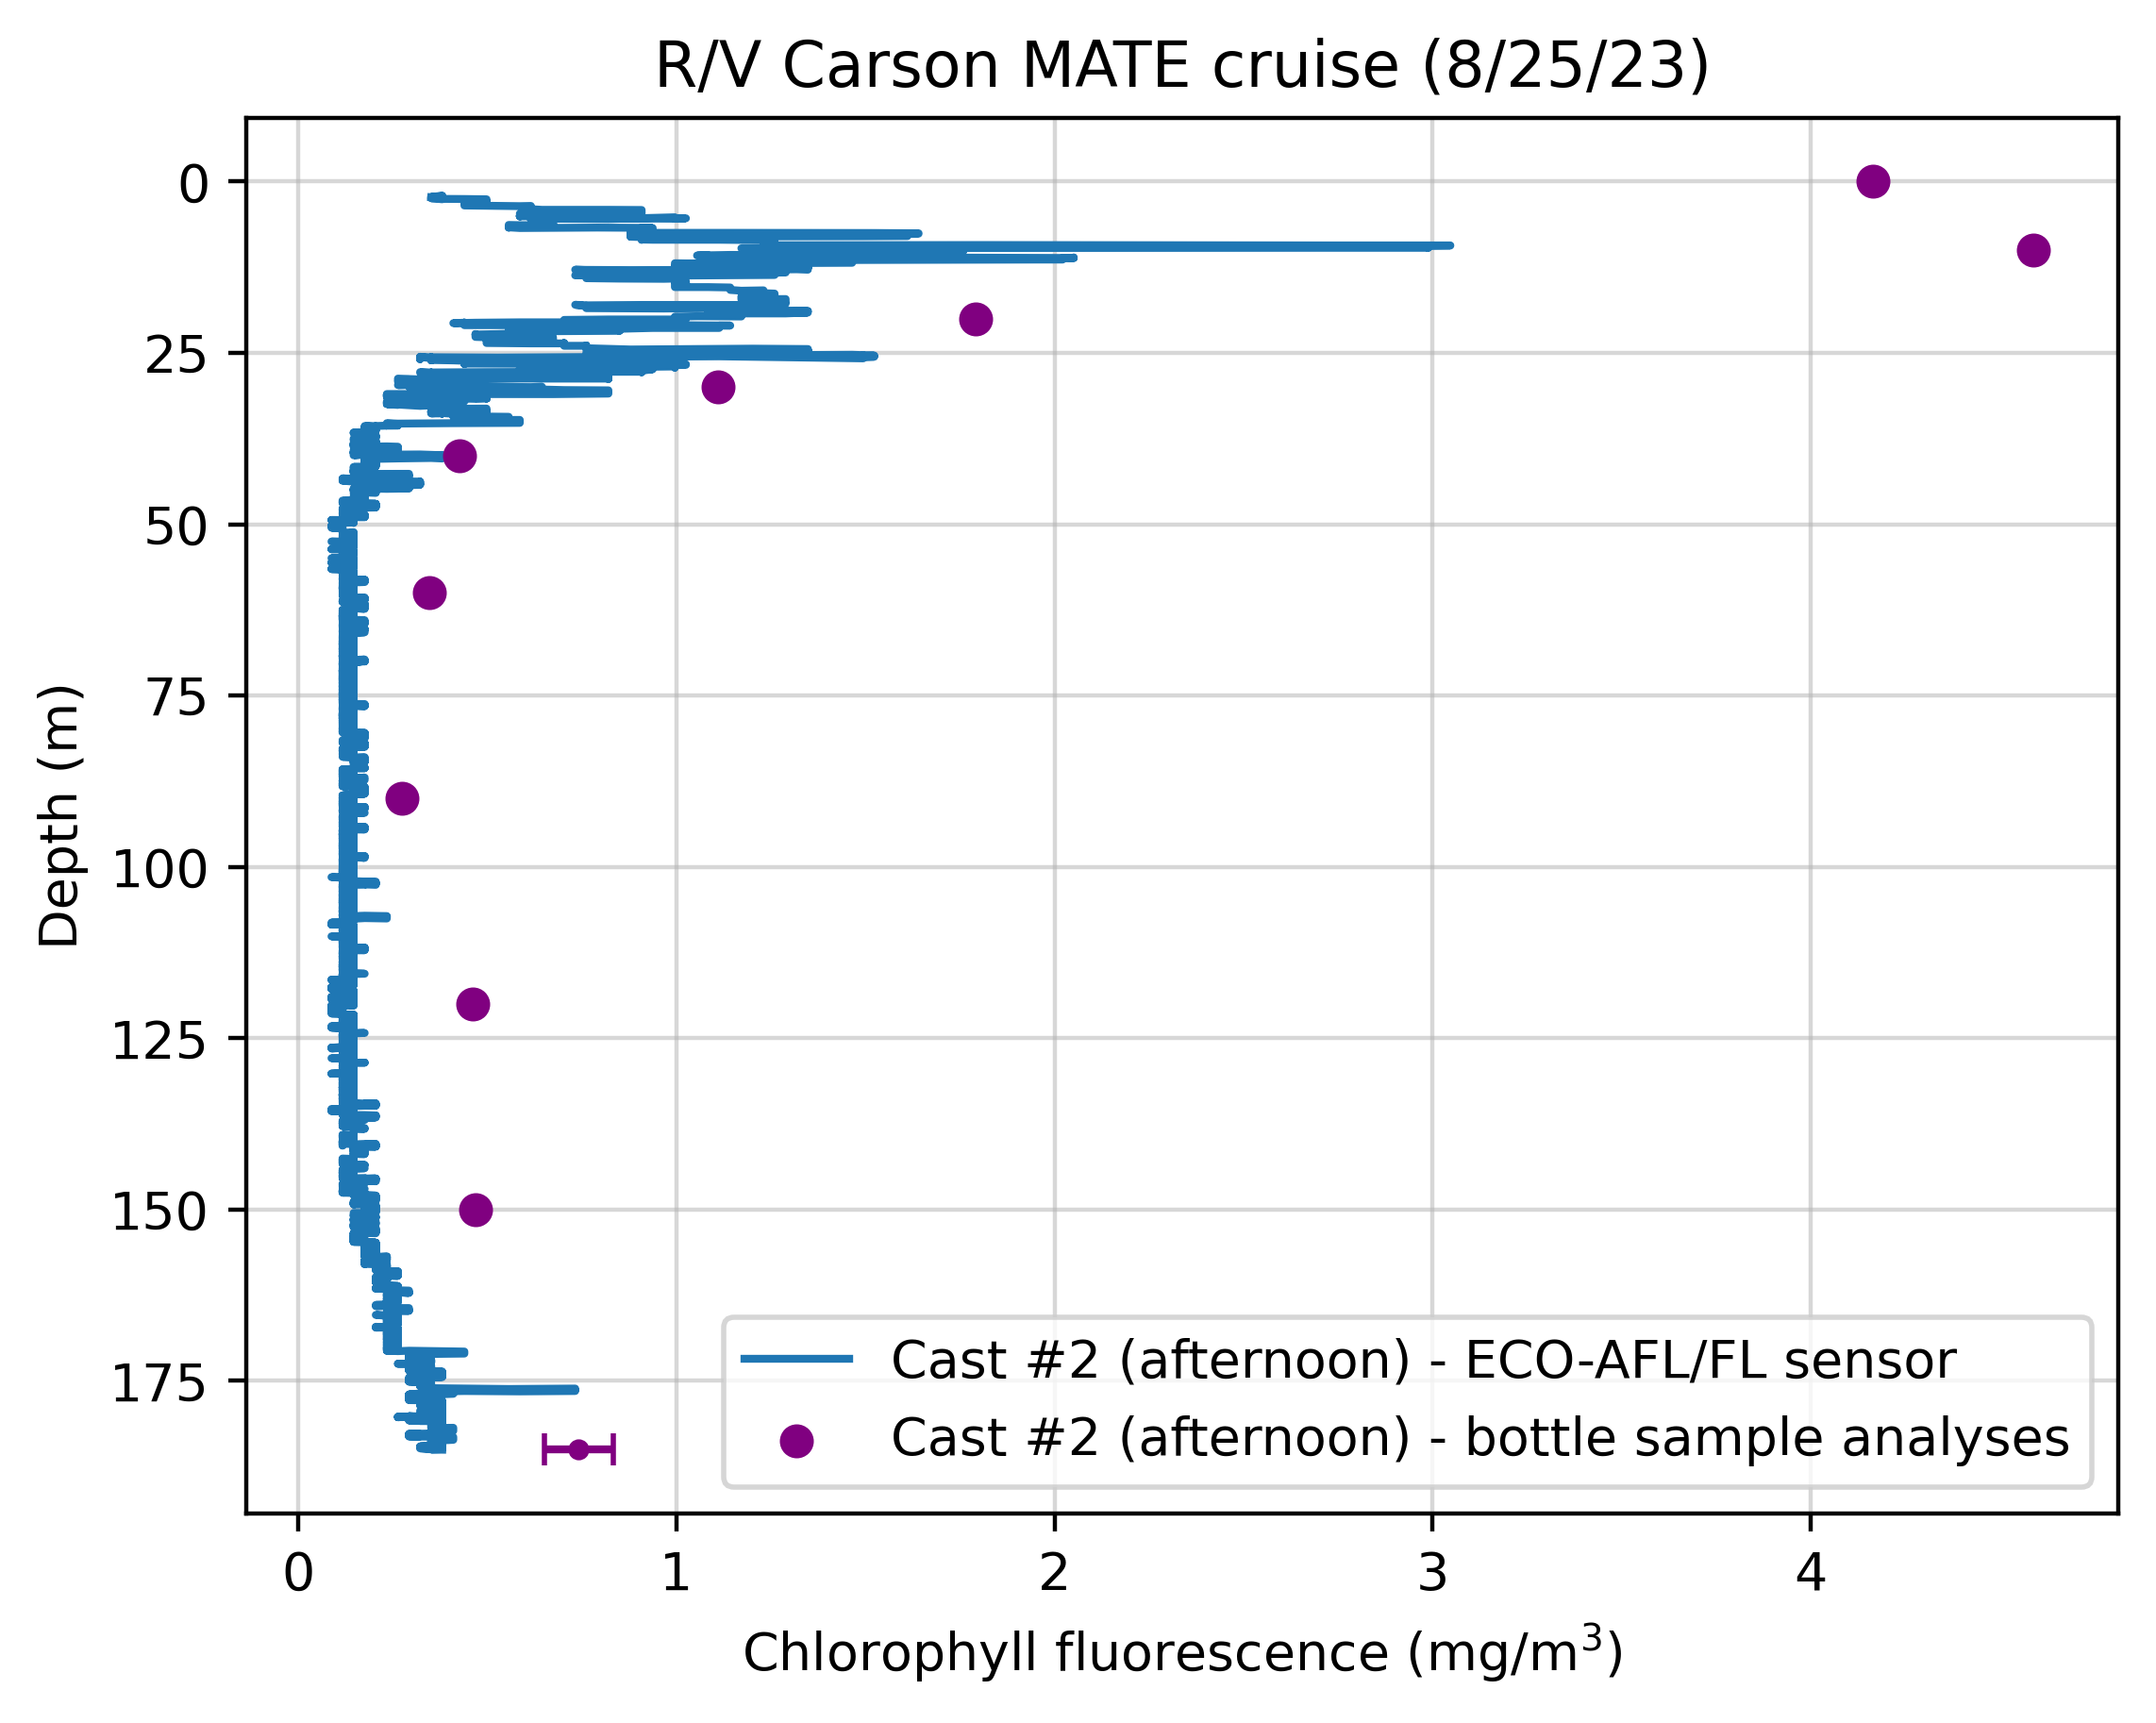

In [ ]:
chl_bot_dep = [[185,185,185],150,120,90,60,40,30,20,10,0]
chl_bot_val = [[0.612,0.813,0.799],0.468,0.460,0.274,0.345,0.426,1.111,1.791,4.589,4.165]

plt.figure(dpi=400)
plt.plot(casts[1]['flECO-AFL'],casts[1]['depSM'],label='Cast #2 (afternoon) - ECO-AFL/FL sensor')
for idx in range(len(chl_bot_dep)):
  if type(chl_bot_val[idx]) is not list:
    if idx == len(chl_bot_dep)-1: label = 'Cast #2 (afternoon) - bottle sample analyses'
    else:                         label = None
    plt.scatter(chl_bot_val[idx],chl_bot_dep[idx],c='purple',s=30,zorder=2,label=label)
  else:
    # plt.scatter(chl_bot_val[idx],chl_bot_dep[idx],c='purple',s=10,marker='x',zorder=2,label=label)
    plt.errorbar(np.mean(chl_bot_val[idx]),np.mean(chl_bot_dep[idx]),xerr=np.std(chl_bot_val[idx]),
                 marker='o',ms=3,capsize=3,c='purple')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Chlorophyll fluorescence (mg/m$^3$)')
plt.ylabel('Depth (m)')
plt.title('R/V Carson MATE cruise (8/25/23)');

In [ ]:
chl_bot_dep[idx]

[185, 185, 185]

## Routine to process glider `.nc` cast files

In [ ]:
filepath = '/content/p1750005.nc'

data = xr.open_dataset(filepath)
display(data)

<xarray.Dataset>
Dimensions:                             (sg_data_point: 340,
                                         magnetometer_data_point: 340,
                                         gc_event: 32, gc_state: 10,
                                         gps_info: 3, trajectory: 1)
Coordinates:
    ctd_time                            (sg_data_point) datetime64[ns] ...
    ctd_depth                           (sg_data_point) float64 ...
    latitude                            (sg_data_point) float64 ...
    longitude                           (sg_data_point) float64 ...
  * trajectory                          (trajectory) int32 5
Dimensions without coordinates: sg_data_point, magnetometer_data_point,
                                gc_event, gc_state, gps_info
Data variables: (12/454)
    time                                (sg_data_point) datetime64[ns] ...
    pressure                            (sg_data_point) float64 ...
    depth                               (sg_data_point) float64 ...
    speed_gsm                           (sg_data_point) float64 ...
    glide_angle_gsm                     (sg_data_point) float64 ...
    horz_speed_gsm                      (sg_data_point) float64 ...
    ...                                  ...
    depth_avg_curr_east_gsm             float64 ...
    depth_avg_curr_north_gsm            float64 ...
    depth_avg_curr_east                 float64 ...
    depth_avg_curr_north                float64 ...
    depth_avg_curr_error                float64 ...
    reviewed                            int32 ...
Attributes: (12/48)
    time_coverage_start:             2023-05-12T19:05:17Z
    time_coverage_end:               2023-05-12T20:05:19Z
    geospatial_lat_min:              47.71529999999999
    geospatial_lat_max:              47.72470982097746
    geospatial_lon_min:              -122.3988
    geospatial_lon_max:              -122.39744937788291
    ...                              ...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.6
    standard_name_vocabulary:        CF-1.6
    featureType:                     trajectory
    cdm_data_type:                   Trajectory
    nodc_template_version:           NODC_NetCDF_Trajectory_Template_v0.9

In [ ]:
data_to_export = data[['time','pressure','depth','temperature','conductivity','salinity',
                       'sigma_theta','density','latitude','longitude','buoyancy','speed',
                       'glide_angle','horz_speed','vert_speed','polar_heading']].drop(['ctd_time','ctd_depth'])

In [ ]:
export_filepath = '/content/20230512_glider.csv'
data_to_export.to_pandas().to_csv(export_filepath)

## Diagnostic plots for glider data

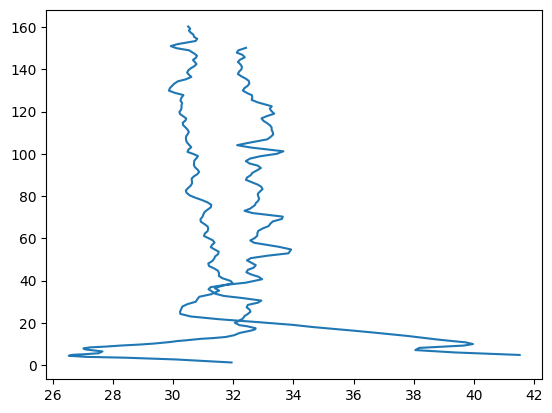

In [ ]:
plt.plot(data['speed'],data['depth'])

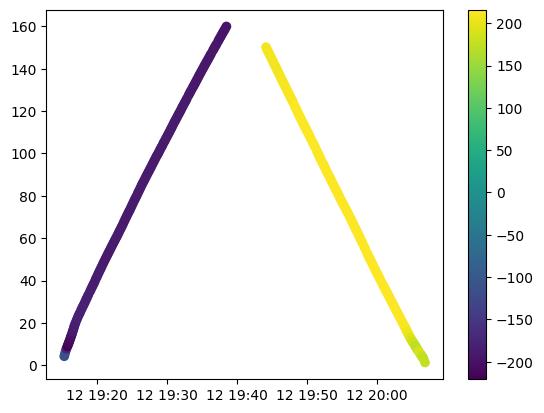

In [ ]:
plt.scatter(data['ctd_time'],data['ctd_depth'],c=data['buoyancy'])
plt.colorbar()

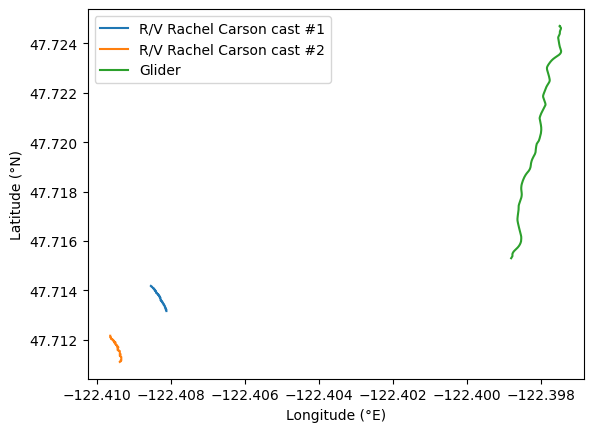

In [ ]:
plt.plot(casts[0]['longitude'],casts[0]['latitude'],label='R/V Rachel Carson cast #1')
plt.plot(casts[1]['longitude'],casts[1]['latitude'],label='R/V Rachel Carson cast #2')
plt.plot(data['longitude'],data['latitude'],label='Glider')

plt.legend()
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)');

(20.0, 0.0)

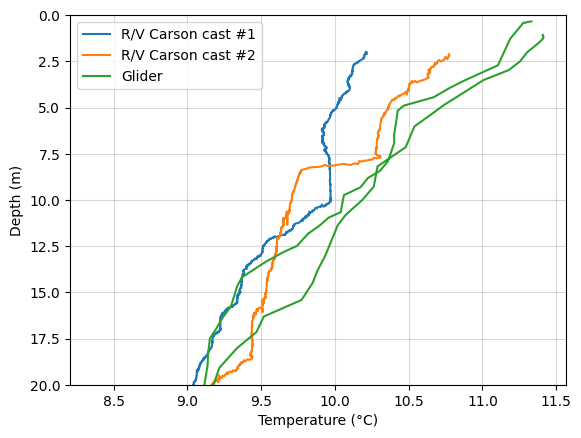

In [ ]:
plt.plot(casts[0]['t090C'],casts[0]['depSM'],label='R/V Carson cast #1')
plt.plot(casts[1]['t090C'],casts[1]['depSM'],label='R/V Carson cast #2')
plt.plot(data['temperature'],data['depth'],label='Glider')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Depth (m)');
plt.ylim([20,0])

(175.0, 130.0)

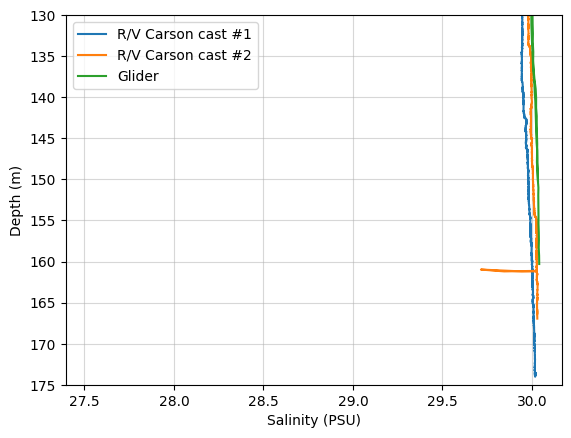

In [ ]:
plt.plot(casts[0]['sal00'],casts[0]['depSM'],label='R/V Carson cast #1')
plt.plot(casts[1]['sal00'],casts[1]['depSM'],label='R/V Carson cast #2')
plt.plot(data['salinity'],data['depth'],label='Glider')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)');
plt.ylim([175,130])

(20.0, 0.0)

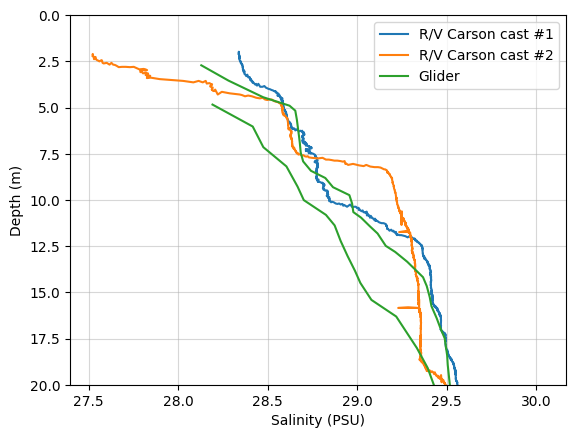

In [ ]:
plt.plot(casts[0]['sal00'],casts[0]['depSM'],label='R/V Carson cast #1')
plt.plot(casts[1]['sal00'],casts[1]['depSM'],label='R/V Carson cast #2')
plt.plot(data['salinity'],data['depth'],label='Glider')
plt.legend()
plt.gca().invert_yaxis()
plt.grid(alpha=0.5)
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)');
plt.ylim([20,0])

In [ ]:
casts[0]['t090C'].mean()

8.731828714198661

In [ ]:
casts[1]['t090C'].mean()

8.751454190571213

In [ ]:
data['temperature'].mean()

<xarray.DataArray 'temperature' ()>
array(8.94580976)